In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

### Загрузим данные

In [ ]:
data = pd.read_csv('proxy_metrics_case_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   views                1200 non-null   int64  
 1   contacts             1200 non-null   int64  
 2   last_7_views         1200 non-null   int64  
 3   last_3_views         1200 non-null   int64  
 4   last_7_contacts      1200 non-null   int64  
 5   last_3_contacts      1200 non-null   int64  
 6   live_days            1200 non-null   int64  
 7   max_messages_events  1200 non-null   int64  
 8   messages_events      1200 non-null   int64  
 9   messages_users       1200 non-null   int64  
 10  avg_contacts_delta   1200 non-null   float64
 11  max_contacts_delta   1200 non-null   int64  
 12  min_contacts_delta   1200 non-null   int64  
 13  is_selling_2         1200 non-null   object 
 14  mumur_advertid       1200 non-null   int64  
dtypes: float64(1), int64(13), object(1)
me

In [ ]:
data.head(10)

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,is_selling_2,mumur_advertid
0,84,2,84,39,2,2,8,0,0,0,0.00,2,-2,Yes,1491863013
1,95,0,95,36,0,0,8,0,0,0,0.00,0,0,Yes,1909318556
2,118,3,118,40,3,2,8,0,0,0,0.17,1,-1,Yes,898271490
3,11,0,11,2,0,0,7,0,0,0,0.00,0,0,Yes,4050431016
4,48,2,48,8,2,0,8,0,0,0,0.00,0,0,Yes,452654590
5,82,0,82,8,0,0,8,0,0,0,0.00,0,0,Yes,2848383124
6,358,8,358,139,8,3,8,0,0,0,-0.33,0,-2,Yes,3955182530
7,62,0,62,17,0,0,8,0,0,0,0.00,0,0,Yes,4267485529
8,61,3,61,19,3,0,8,0,0,0,0.00,0,0,Yes,3354163163
9,148,1,148,25,1,0,8,0,0,0,0.00,1,-1,Yes,1485920549


### Вспомним алгоритм работы с прокси-метриками и напишем функцию для проверки корреляции

Полезные ссылки по расчету корреляций между категориальными и количественными переменными:

- https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
- https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
- https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118445112.stat06227
- https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Алгоритм работы с прокси метриками:
- найти хороших кандидатов на прокси метрики
- провести корреляционный анализ
- доработать первичный список
- проверить мощность и уровень значимости теста
- проверить на реальном АБ-тесте позволяет ли прокси-метрика детектить изменение целевой метрики. Анализ чувствительности прокси-метрики

In [ ]:
# напишем функцию, которая проверяет наличие корреляции
# между категориальной и количественной переменной

def find_cat_quant_correlation(quant_value, binary_mask, plot = True, print_inference = True):
    '''
    quant_value - количественная переменная,  для которой считаем корреляцию
    binary_mask - бинарная переменная (True, False), для которой считаем корреляцию
    plot - надо ли отрисовывать график
    print_inference - надо ли принтовать выводы и основные метркии
    '''

    # разбиваем количественную метрику на группы по тому, была ли целевая конверсия или нет
    group_1 = quant_value[binary_mask] # binary = 1
    group_2 = quant_value[~binary_mask] # binary = 0

    # считаем pointbiserial корреляцию, тест Краскелла-Уолесса и обычный Т-тест
    pointbiserialr = ss.pointbiserialr(quant_value, binary_mask)[0]
    kruskal_pval = ss.kruskal(group_1, group_2)[1]
    ttest_pval = ss.ttest_ind(group_1, group_2)[1]

    # принтуем выводы
    if print_inference:
        print('Mean quant value for group (binary=1) =', group_1.mean())
        print('Mean quant value for group (binary=0) =', group_2.mean())

        print('Median quant value for group (binary=1) =', group_1.median())
        print('Median quant value for group (binary=0) =', group_2.median())

        print('Kruskal-Wallis H Test p-value =', kruskal_pval)
        print('T-test p-value =', ttest_pval)
        print('point biserial correlation =', pointbiserialr)

    # рисуем график распределения для двух групп, чтобы проиллюстрировать различия в группах
    if plot:
        plt.figure(figsize=(16,6))
        sns.kdeplot(group_1, color = 'red', label = 'Binary = True')
        sns.kdeplot(group_2, color = 'blue', label = 'Binary = False')
        plt.axvline(x = group_1.mean(), linestyle = '--', color = 'red')
        plt.axvline(x = group_2.mean(), linestyle = '--', color = 'blue')
        plt.legend()

    return({'point biserial R':pointbiserialr,
            'kruskal_pval':kruskal_pval,
            'ttest_pval':ttest_pval})

{'point biserial R': 0.19401064582973623,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

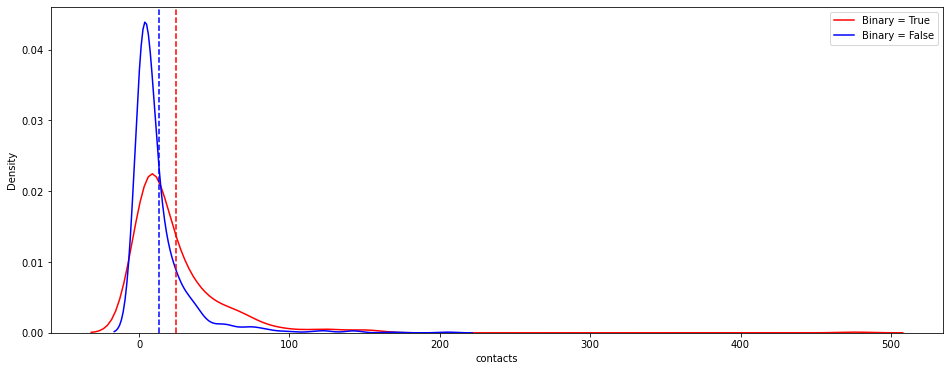

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = False)

### Ищем пороги для прокси-метрики

In [ ]:
# напишем функцию для визуализации и поиска оптимальных порогов для создания прокси-метрики

def proxy_metrics_bins_analizer(quant_value, binary_mask, step):

    #разбиваем исходную количественную величину на квантили с нужным шагом
    deciles_bins = np.quantile(quant_value, np.arange(0, 1, step))
    #разбиваем ряд на бины
    inds = np.digitize(quant_value, deciles_bins, right = False)
    # агрегируем
    df = pd.DataFrame({'quant_value':quant_value,
                  'binary': binary_mask,
                  'bins': inds})
    inference = df.groupby('bins').mean()

    #считаем point biserial корреляцию
    point_biserial_R = find_cat_quant_correlation(quant_value = quant_value, binary_mask=binary_mask, plot = False, print_inference = False)['point biserial R']

    # рисуем график
    plt.figure(figsize=(12,6))
    sns.lineplot(y = inference['quant_value'], x = inference.index*step, color = 'red', label = 'quant_value')
    plt.axhline(y = quant_value.median(), linestyle = '--', color = 'red')
    plt.text(x = inds.mean()*step, y = np.quantile(quant_value, 0.95), s ='point_biserial_R = {}'.format(point_biserial_R), )
    ax2 = plt.twinx()
    sns.lineplot(y = inference['binary'], x = inference.index*step, color = 'blue', ax=ax2, label = 'binary share')
    plt.axhline(y = binary_mask.mean(), linestyle = '--', color = 'blue')
    plt.legend()

### Рассмотрим метрику Просмотры

Посмотрим, есть ли различия в распределении просмотров в зависимости от того, продали ли авто или нет

Mean quant value for group (binary=1) = 1017.3844282238443
Mean quant value for group (binary=0) = 732.106463878327
Median quant value for group (binary=1) = 500.0
Median quant value for group (binary=0) = 368.0
Kruskal-Wallis H Test p-value = 0.00011486887007781793
T-test p-value = 0.00018505614391999982
point biserial correlation = 0.10772185104605951


{'point biserial R': 0.10772185104605951,
 'kruskal_pval': 0.00011486887007781793,
 'ttest_pval': 0.00018505614391999982}

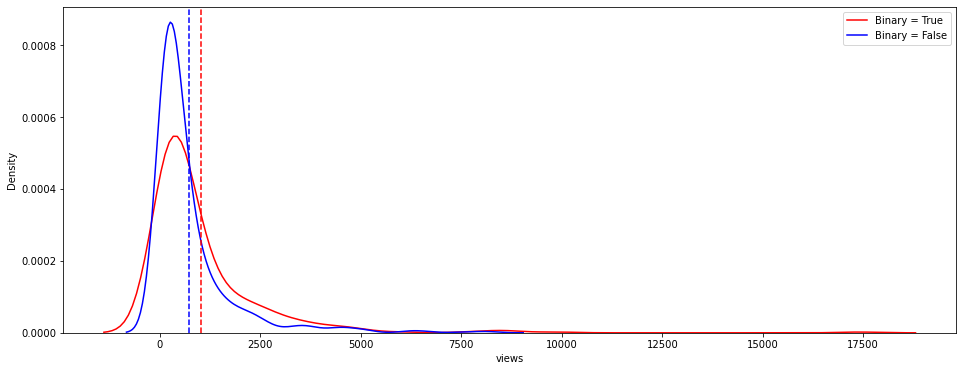

In [ ]:
find_cat_quant_correlation(quant_value = data['views'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Видим, что распределения и средние явно различаются (стат критерии показывают различия в средних), но корреляция недостаточно высокая.

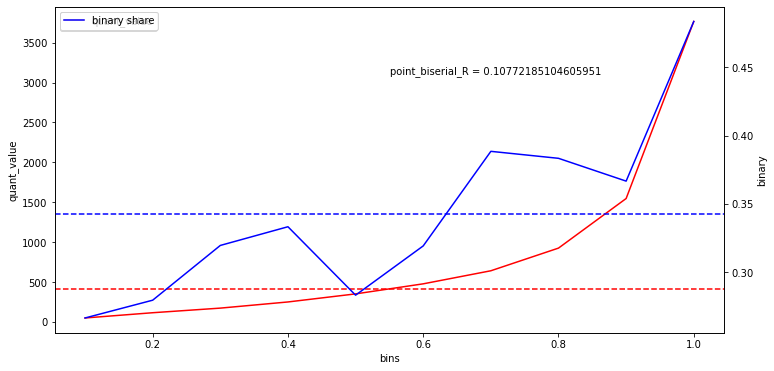

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['views'], binary_mask=data['is_selling_2']=='Sold', step = 0.1)

Есть скачок конверсии после 0,6 квантиля.

В целом видно, что просмотры отлавливают влияние на рост вероятности продать авто. Но видно, что есть много других факторов, размывающих влияние. Попробуем поискать еще хорошие варианты метрик

### Рассмотрим метрику суммарные контакты

Mean quant value for group (binary=1) = 24.284671532846716
Mean quant value for group (binary=0) = 13.135614702154626
Median quant value for group (binary=1) = 12.0
Median quant value for group (binary=0) = 6.0
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2166186100304946e-11
point biserial correlation = 0.19401064582973623


{'point biserial R': 0.19401064582973623,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

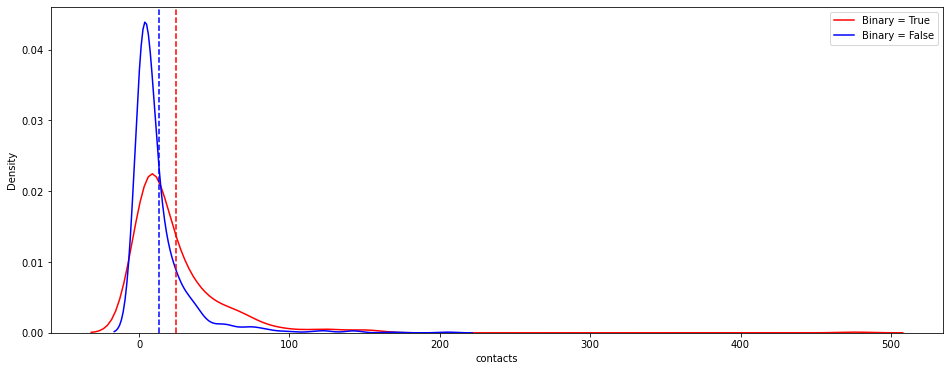

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Мера различий между группами (p-value в критериях) выглядит более значимой. Так же, как и уровень корреляции. Значит, мы двигаемся в правильном направлении.

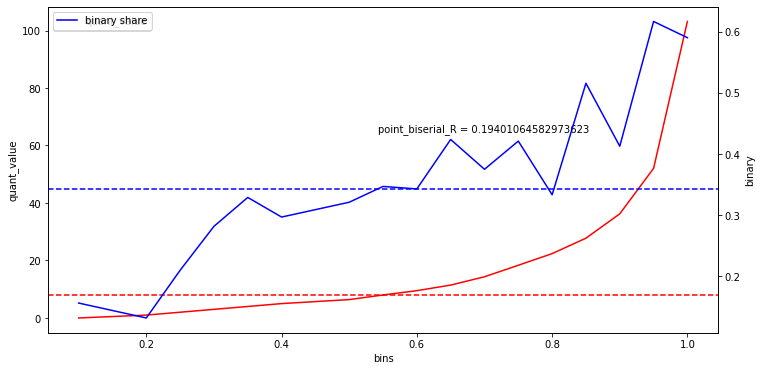

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['contacts'], binary_mask=data['is_selling_2']=='Sold', step = 0.05)

Видно, что между контактами и долей проданных автомобилей есть корреляция

### Преобразуем немного метрику контактов

Mean quant value for group (binary=1) = 2.618697674792375
Mean quant value for group (binary=0) = 1.9687405430469196
Median quant value for group (binary=1) = 2.5649493574615367
Median quant value for group (binary=0) = 1.9459101490553132
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2127397196980984e-19
point biserial correlation = 0.25760737743473805


{'point biserial R': 0.25760737743473805,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2127397196980984e-19}

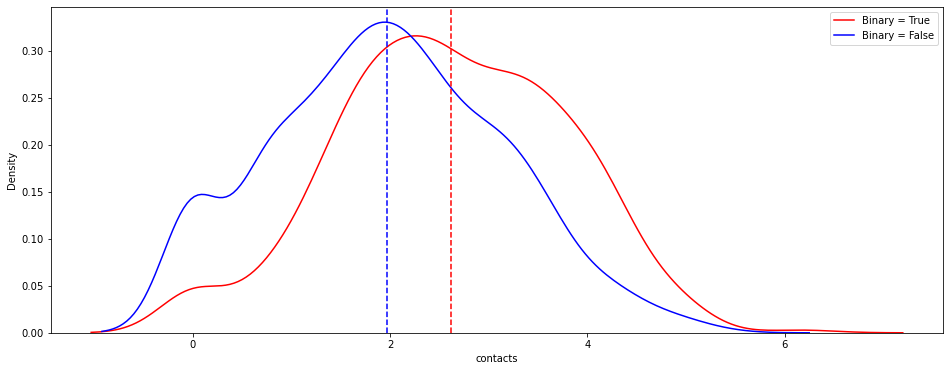

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

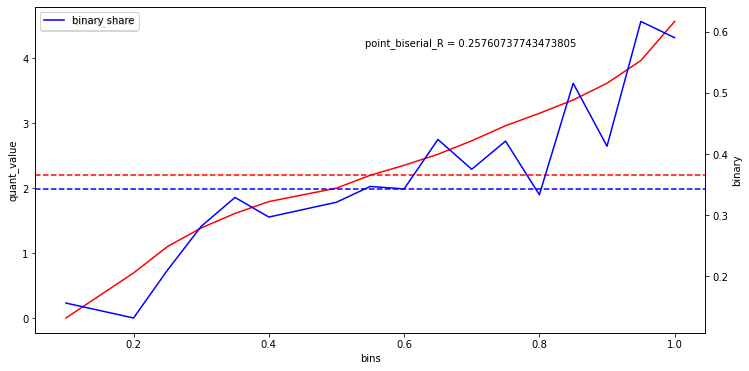

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

После преобразования метрики контактов корреляция стала видна еще сильнее. То, что логарифм работает на корреляцию лучше, говорит о том, что вероятность сконтактировать прирастает нелинейно от количества контактов.

### Рассмотрим метрику live days

Кажется, что количество проведенных в листинге дней также должно повышать вероятность продажи. Давайте рассмотрим, как эта метрика влияет на вероятность продажи.

Mean quant value for group (binary=1) = 10.150851581508515
Mean quant value for group (binary=0) = 12.724968314321927
Median quant value for group (binary=1) = 8.0
Median quant value for group (binary=0) = 8.0
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 7.710755933111699e-06
point biserial correlation = -0.12872277961206446


{'point biserial R': -0.12872277961206446,
 'kruskal_pval': 1.1322319834713854e-14,
 'ttest_pval': 7.710755933111699e-06}

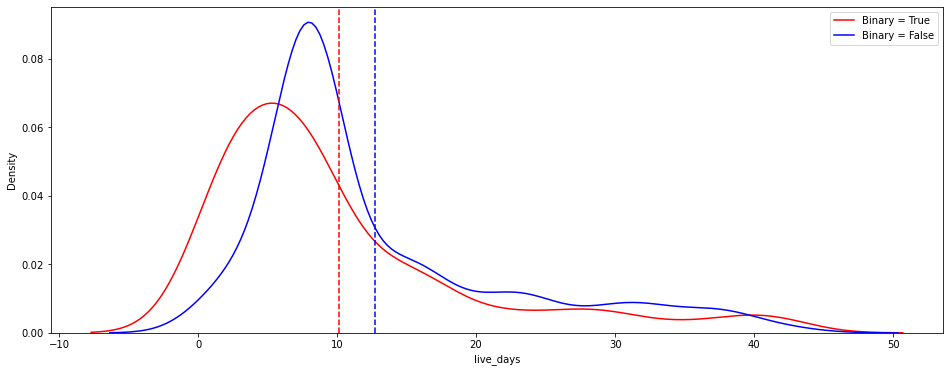

In [ ]:
find_cat_quant_correlation(quant_value = (data['live_days']), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

Видно, что длительность пребывания в live влияет на вероятность продать автомобиль. При этом вероятность падает с ростом длительности присутствия в live. Также кажется, что влияние длительности нелинейное, поэтому попробуем преобразовать метрику.

Mean quant value for group (binary=1) = 1.903649116406305
Mean quant value for group (binary=0) = 2.3032503171939456
Median quant value for group (binary=1) = 2.0794415416798357
Median quant value for group (binary=0) = 2.0794415416798357
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 6.349534248658027e-16
point biserial correlation = -0.230413096668318


{'point biserial R': -0.230413096668318,
 'kruskal_pval': 1.1322319834713854e-14,
 'ttest_pval': 6.349534248658027e-16}

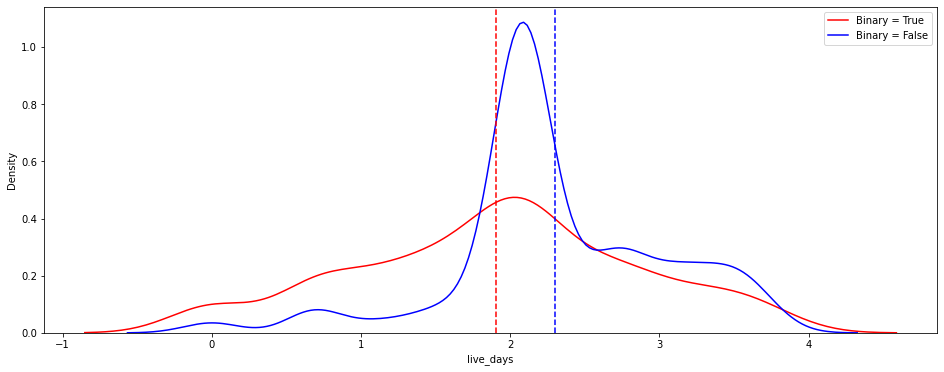

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['live_days']), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

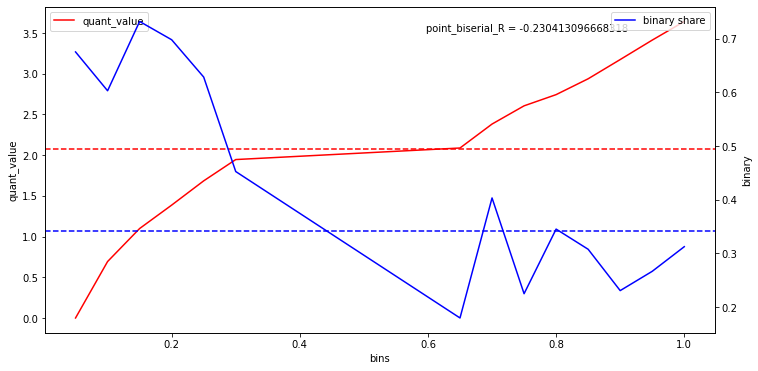

In [ ]:
proxy_metrics_bins_analizer( np.log(data['live_days']), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

Видим, что метрика длительности пребывания в тесте важная для определения вероятности совершения продажи. Но сама по себе все еще несет не достаточно сильную корреляцию.

### Рассмотрим соотношение контактов к просмотрам

Кажется, что хорошим кандидатом на прокси-метрику, предсказывающим вероятность совершения контактов может быть соотношение контактов к просмотрам у объявления. "Хорошее" объявление должно набирать большее кол-во контактов на объем просмотров. Проверим это предположение.

Mean quant value for group (binary=1) = 0.034516588734782555
Mean quant value for group (binary=0) = 0.022656793552670397
Median quant value for group (binary=1) = 0.02557544757033248
Median quant value for group (binary=0) = 0.015267175572519083
Kruskal-Wallis H Test p-value = 2.1088451078274545e-17
T-test p-value = 9.972214444692406e-11
point biserial correlation = 0.18527145231954217


{'point biserial R': 0.18527145231954217,
 'kruskal_pval': 2.1088451078274545e-17,
 'ttest_pval': 9.972214444692406e-11}

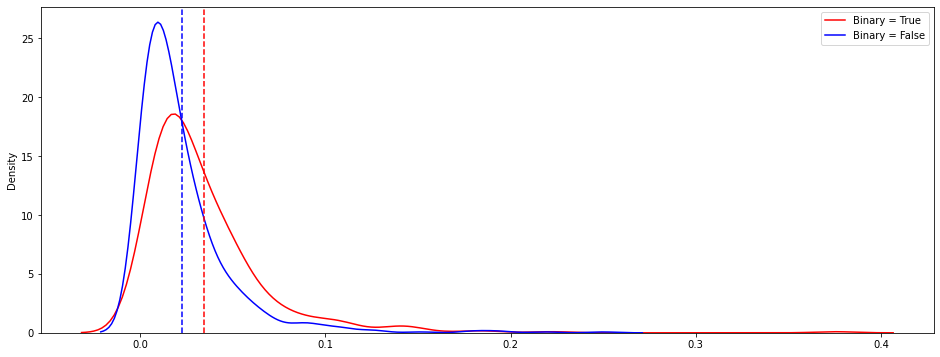

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'] / (data['views']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

C:\Users\kazakov\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


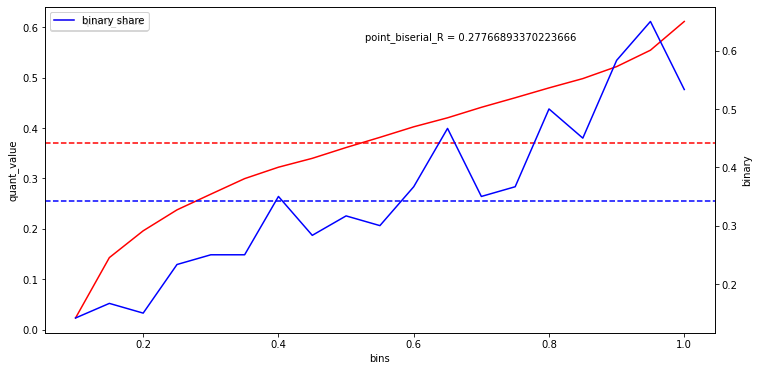

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['views']), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

### Рассмотрим скорость набора контактов (в зависимости от кол-ва дней в live)

Кажется, что чем быстрее объявление набирает контакты, тем вероятнее произойдет продажа. Проверим это предположение.

Mean quant value for group (binary=1) = 2.785472683880675
Mean quant value for group (binary=0) = 1.1170922804394388
Median quant value for group (binary=1) = 1.6666666666666667
Median quant value for group (binary=0) = 0.6428571428571429
Kruskal-Wallis H Test p-value = 4.811812489816918e-44
T-test p-value = 1.5839426375159415e-35
point biserial correlation = 0.3481797802322052


{'point biserial R': 0.3481797802322052,
 'kruskal_pval': 4.811812489816918e-44,
 'ttest_pval': 1.5839426375159415e-35}

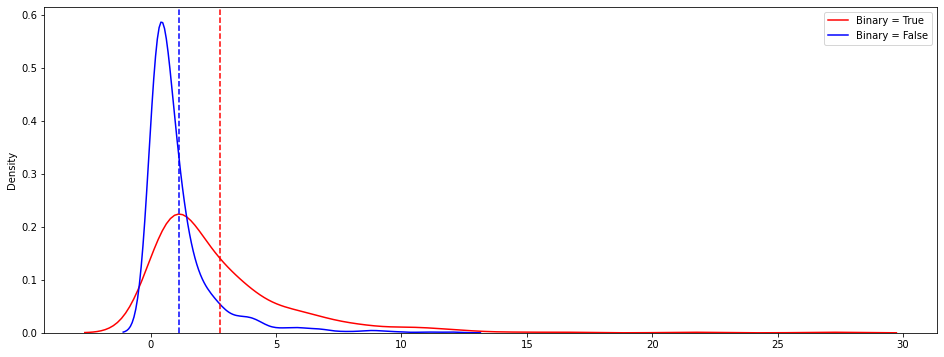

In [ ]:
find_cat_quant_correlation(quant_value = (data['contacts']+1) / (data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

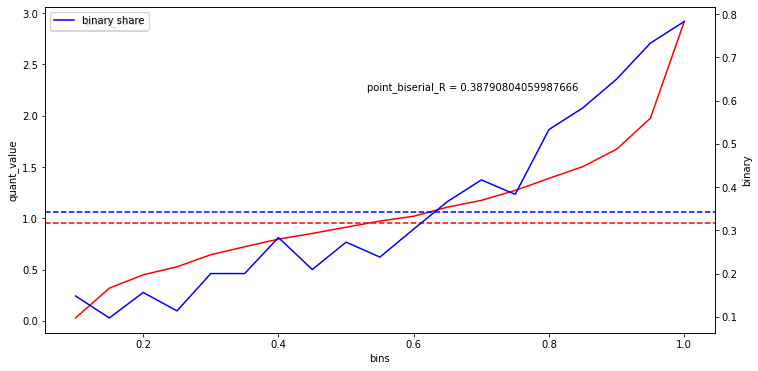

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05)

### Рассмотрим метрику контакты за последние несколько дней перед уходом в архив

Метрика набора контактов за последние три дня сочетает в себе и подсчет контактов, и метрику скорости. Посмотрим, будет ли это хорошим кандидатом на эту роль

Mean quant value for group (binary=1) = 16.124087591240876
Mean quant value for group (binary=0) = 7.108998732572877
Median quant value for group (binary=1) = 10.0
Median quant value for group (binary=0) = 4.0
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 4.1409370143423566e-23
point biserial correlation = 0.2803453016021136


{'point biserial R': 0.2803453016021136,
 'kruskal_pval': 3.1821541212660747e-29,
 'ttest_pval': 4.1409370143423566e-23}

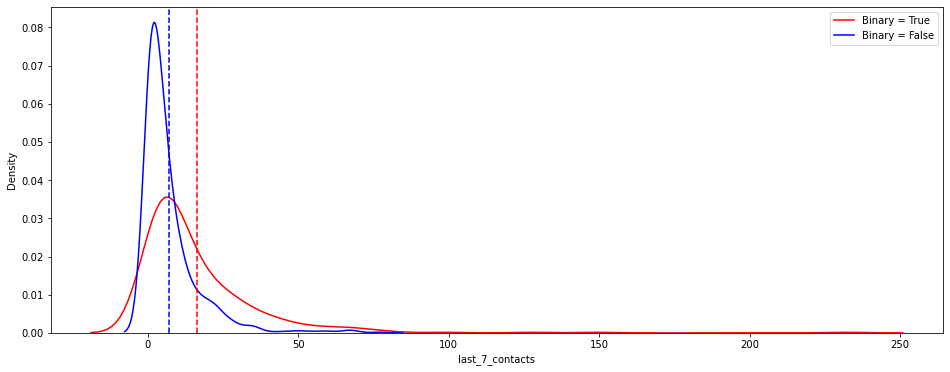

In [ ]:
find_cat_quant_correlation(quant_value = data['last_7_contacts'], binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

попробуем логарифмировать

Mean quant value for group (binary=1) = 2.3224548692436144
Mean quant value for group (binary=0) = 1.5626914772082992
Median quant value for group (binary=1) = 2.3978952727983707
Median quant value for group (binary=0) = 1.6094379124341003
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 1.7156887701776706e-31
point biserial correlation = 0.3279958353814851


{'point biserial R': 0.3279958353814851,
 'kruskal_pval': 3.1821541212660747e-29,
 'ttest_pval': 1.7156887701776706e-31}

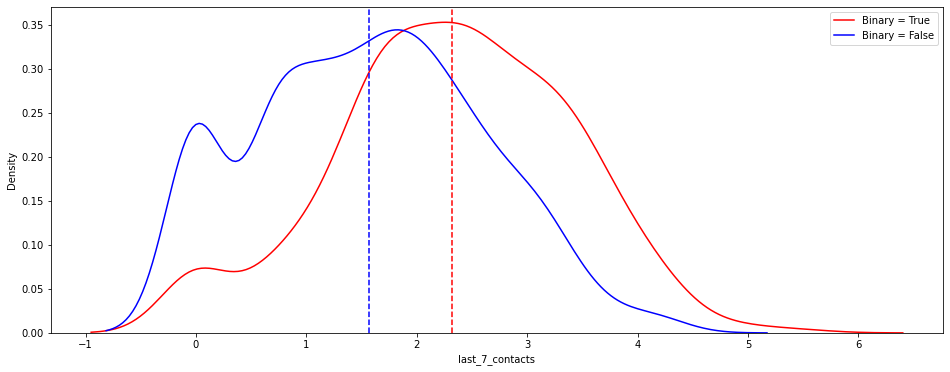

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_7_contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

На графике явно видно, что группа, продавшая авто, получала перед уходом в архив больше контактов. И при этом доля тех, кто получил контактов больше 0 у "продавших" значительно ниже

Mean quant value for group (binary=1) = 1.8937351686159294
Mean quant value for group (binary=0) = 0.9443381111904835
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 1.1733129557672549e-45
T-test p-value = 6.05383456974365e-52
point biserial correlation = 0.4180024619744417


{'point biserial R': 0.4180024619744417,
 'kruskal_pval': 1.1733129557672549e-45,
 'ttest_pval': 6.05383456974365e-52}

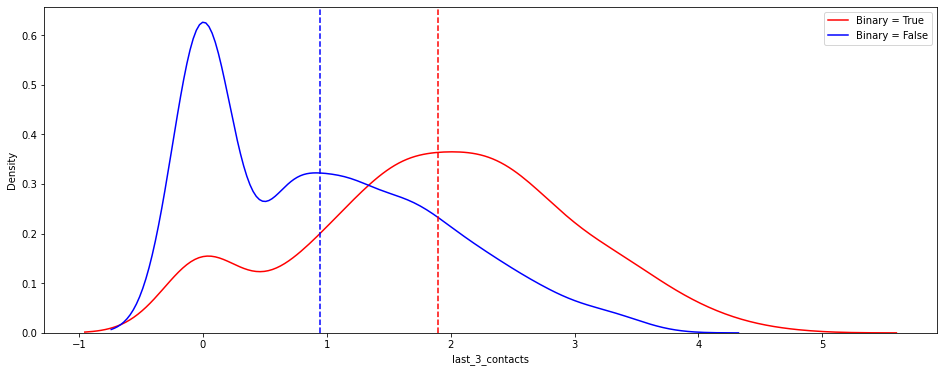

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_selling_2']=='Sold', plot = True, print_inference = True)

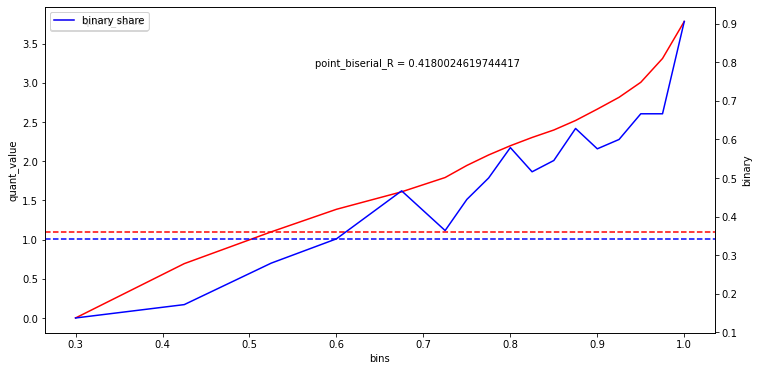

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.025)

Мы нашли неплохого кандидата на роль прокси-метрики для факта продажи авто - набранное кол-во контактов за 3 дня перед уходом в архив. Теперь попробуем превратить эту метрику в бинарную.

### Перебираем пороги для максимизации корреляции между двумя бинарными метриками

Согласно визуальному анализу стоит начать перебор параметров от медианы и выше, но также необходимо посмотреть и долю пользователей не получавших контакты перед уходом в архив

In [ ]:
# доля бесконтактных
(data['last_3_contacts']== 0).sum() / len(data)

0.2925

Для оценки ассоциации (корреляции) между двумя бинарными переменными используется cramer V статистика

https://towardsdatascience.com/how-strongly-associated-are-your-variables-80493127b3a2

https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6

In [ ]:
#создадим функцию для оценки ассоциации двух бинарных переменных
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return (cramers_v)

In [ ]:
# для примера давайте рассмотрим корреляцию между следующими метриками
confusion_matrix = pd.crosstab(data['is_selling_2']=='Sold', data['last_3_contacts']>4)
cramers_v(confusion_matrix.values)

0.3413854425014344

In [ ]:
#попробуем найти порог, при котором коэффициент ассоциации cramer V будет максимальным

def max_cramerv_corr_finder(quant_value, binary_mask, plot = True, print_inference = True, step = 1):
    '''
    quant_value - исходная количественная переменная по которой мы пытаемся найти порог
    binary_mask - бинарная метрика с целевой конверсией к которой мы исщем максимальную корреляцию
    plot - нужно ли рисовать граиф
    print_inference - нужно ли принтовать выводы
    step - размер шага с которым мы идем по quant_value и определяем пороги
    '''
    # определяем вектор исходной количественной переменной, на котором мы будет искать максимальную корреляцию
    arange = np.arange(min(quant_value), max(quant_value), step)
    cramers_v_list = []

    #циклом проходим по всем порогам и находим значение cramers_v
    for i in arange:
        confusion_matrix = pd.crosstab(binary_mask, quant_value>i)
        cramers_v_i = cramers_v(confusion_matrix.values)
        cramers_v_list.append(cramers_v_i)

    # сохраняем максимальные найденные значения корреляции и порога, при котором она достигается
    max_corr_quant_value = arange[np.argmax(np.array(cramers_v_list))]
    max_cramer_v = max(cramers_v_list)

    # отрисовываем график
    if plot:
        sns.lineplot(x = arange, y = cramers_v_list)
        plt.axhline(y = np.array(cramers_v_list).max(), linestyle = '--', color = 'red')
        plt.axvline(x = max_corr_quant_value, linestyle = '--', color = 'red')
        plt.xlabel('quant values')
        plt.ylabel('Cramer-V')

    ## принтуем выводы
    if print_inference:
        print('Maximum Cramer V =', np.array(cramers_v_list).max())
        print('Maximum Cramer V quant value = ', max_corr_quant_value)

    return({'max_cramer_v': max_cramer_v,
           'max_corr_quant_value': max_corr_quant_value})

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  3


{'max_cramer_v': 0.3686253838357947, 'max_corr_quant_value': 3}

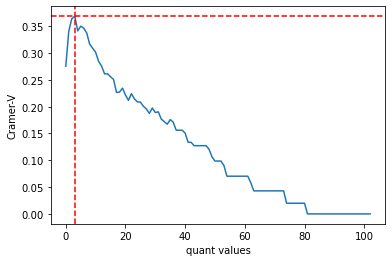

In [ ]:
max_cramerv_corr_finder(data['last_3_contacts'], data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 1)

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  1.4000000000000001


{'max_cramer_v': 0.3686253838357947,
 'max_corr_quant_value': 1.4000000000000001}

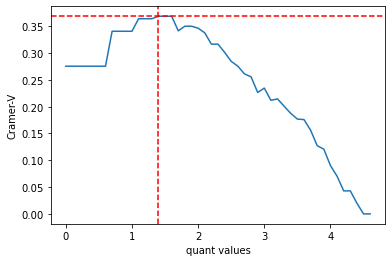

In [ ]:
# давайте попробуем прогнать этот кусочек с логарифмированной метрикой
max_cramerv_corr_finder(np.log(data['last_3_contacts']+1), data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 0.1)

In [ ]:
# преобразуем в исходную шкалу полученное рекомендованное значение
np.exp(1.4)-1

3.0551999668446745

Итак мы нашли, что по историческим данным наилучшая корреляция достигается при 3+ уровне контактов за 3 дня перед отправкой в архив

### Проверим чувствительность такой метрики для теста на конверсию

Проверка через А/Б-тест заключается в том, сможем ли мы находить реальные изменения в целевой метрике, наблюдая изменения в прокси-метрике.
Для этого необходим реально проведенный А/Б-тест, где есть найденное изменение в целевой метрике.
Либо, где эффекта в целевой метрике нет, и мы смотрим, как часто наша прокси метрика говорит, что эффект все-таки есть.

In [ ]:
#AA test simulation on target metric
# проведем симуляцию оценки равенства долей двумя способами. Непосредственно оценку доли проданных
# и оценку тех, кто набрал 3+ контактов за период до ухода в архив

aa_binary_ztest_pvalue_list = []
aa_quant_ztest_pvalue_list = []
quant_target_level = 3
n_sim = 1000

for i in range(1000):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = binary_mask_group_b.sum()
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = (quant_value_group_b >= quant_target_level).sum()

    #проведем z-test для оценки равенства долей в двух группах
    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    aa_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    aa_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_alpha_ci = proportion_confint((np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_alpha_ci = proportion_confint((np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Количество случаев ложного прокраса теста при оценке доли продавших:', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля продавших):', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших)', binary_alpha_ci)
print('------------------')
print('Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня:',(np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля набравших 3+):', (np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших)', quant_alpha_ci)

Количество случаев ложного прокраса теста при оценке доли продавших: 50
Уровень статистической значимости оценки (доля продавших): 0.05
99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших) (0.03224732165140968, 0.06775267834859033)
------------------
Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня: 52
Уровень статистической значимости оценки (доля набравших 3+): 0.052
99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших) (0.033914816482989676, 0.07008518351701032)


Как мы видим, уровень альфа на А/А-тестах выдерживается в заданных рамках. Посмотрим как будет вести себя на А/Б-симуляциях

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 1000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)



print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_alpha_ci)


print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)

Effect = 0.1
Sample size A group = 599
Sample size B group = 601
Target conversion A group =  0.3555926544240401
Target conversion B group =  0.3627287853577371
Proxy conversion A group =  0.4974958263772955
Proxy conversion B group =  0.5158069883527454
Мощность АБ-теста по целевой метрике 0.229
99%-процентный доверительный интервал для мощности (доля продавших) (0.03224732165140968, 0.06775267834859033)
Мощность АБ-теста по прокси метрике 0.37


Как мы видим, мощность теста по прокси-метрике немного выше, чем по основной. Связано это с различем в долях. Доля пользователей с кол-вом контактов больше или равно трех выше, чем тех, кто продал авто. Это разница влияет на то, какое кол-во пользователей нам необходимо, чтобы задетектить ожидаемый размер эффекта.
Поэтому на ограниченной выборке мы можем задетектить.

### Проверим, как ведет себя прокси метрика на реальном АБ-тесте

Мы решили использовать метрику "кол-во контактов за 3 дня до ухода в архив" как прокси-метрику для конверсии в продажу авто. По симуляциям метрика выглядела неплохо.

Теперь нам нужно проверить причинно-следственные связи на практике. Для этого проведем А/Б-тест, влияющий на набор контактов. И одновременно с ним будем проводить обзвон пользователей, ушедших в архив, чтобы определить, продали ли они автомобиль на самом деле.

Это позволит нам узнать истинный эффект от нововедения на долю продаваемых и эффект на набор контактов в последние 3 дня перед архивом.
Сопоставив эти два результата, мы поймем позволяет ли прокси-метрика находить эффекты на долю проданных авто.

Загрузим данные по АБ-тесту

In [ ]:
ab_test_data = pd.read_csv('proxy_metrics_case_abtest.csv')

In [ ]:
ab_test_data.head()

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,mumur_advertid,AB_test_group,is_selling_3
0,72,0,19,7,0,0,15,1,1,1,0.00,0,0,1228156847,0,0
1,2040,20,252,87,6,5,27,2,14,12,0.00,0,0,1111412596,1,1
2,4105,56,757,223,10,3,39,3,19,17,0.00,0,0,2292183779,1,0
3,4568,39,854,236,7,3,41,3,29,23,-0.17,2,-2,772897149,1,1
4,56,3,56,10,3,4,7,0,0,0,0.00,2,-1,1598865363,1,1


In [ ]:
# посмотрим есть ли различия в доле продающих пользователей между двумя группами
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).mean())
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).mean())

0.3665997993981946
0.33732136922565636


In [ ]:
# посмотрим есть ли различия в доле пользователей, набравших больше 3 контактов между двумя группами
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).mean())
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).mean())

0.4745904379806085
0.4230641409106015


Даже беглый взгляд говорит, что мы можем детектить эффект и через прокси метрику. Давайте посмотрим, что скажут стат критерии.

In [ ]:
# АБ-тест доли продавших
binary_counts_group_a = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).sum()
binary_counts_group_b = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).sum()

binary_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
binary_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

binary_z_score, binary_ztest_pvalue = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

print('Proportion abs uplift:', (binary_counts_group_b/binary_nobs_group_b) - (binary_counts_group_a/binary_nobs_group_a))
print('Proportion rel uplift:', (binary_counts_group_b/binary_nobs_group_b)/(binary_counts_group_a/binary_nobs_group_a) - 1)
print('Z-test p-value:', binary_ztest_pvalue)

Proportion abs uplift: 0.029278430172538228
Proportion rel uplift: 0.08679684373316987
Z-test p-value: 0.0007852964424626157


In [ ]:
# АБ-тест доли набравших 3+
quant_counts_group_a = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).sum()
quant_counts_group_b = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).sum()

quant_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
quant_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

quant_z_score, quant_ztest_pvalue = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

print('Proportion abs uplift:', (quant_counts_group_b/quant_nobs_group_b) - (quant_counts_group_a/quant_nobs_group_a))
print('Proportion rel uplift:', (quant_counts_group_b/quant_nobs_group_b)/(quant_counts_group_a/quant_nobs_group_a) - 1)
print('Z-test p-value:', quant_ztest_pvalue)

Proportion abs uplift: 0.051526297070007
Proportion rel uplift: 0.12179310909949015
Z-test p-value: 1.3926986115308757e-08


Как мы видим в обоих метриках есть изменения в доле. Это говорит о том, что мы можем использовать  данную прокси-метрику для того, чтобы находить эффекты в целевой метрике.